In [61]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import cv2

import albumentations as A
from albumentations.pytorch import ToTensorV2

import numpy as np # data processing
import matplotlib.pyplot as plt # Data visualization
from tqdm import tqdm # Progress bar

In [62]:
import os
import pandas as pd 

root_dir = "Snake_Images/train/" # Insert your data here
sub_folders = ["Venomous", "Non_Venomous"] # Insert your classes here
labels = [0, 1]

data = []

for s, l in zip(sub_folders, labels):
    for r, d, f in os.walk(root_dir + s):
        for file in f:
            if ".jpg" in file:
                data.append((os.path.join(s,file), l))

df = pd.DataFrame(data, columns=['file_name','label'])
print(df)

                                              file_name  label
0             Venomous/texas-teen-suicide-snakebite.jpg      0
1                        Venomous/hqdefault_007 (3).jpg      0
2                               Venomous/IMG_3809-2.jpg      0
3     Venomous/indian-cobra-spectacled-cobra-naja-na...      0
4                            Venomous/kingcobra-002.jpg      0
...                                                 ...    ...
1777                                Non_Venomous/19.jpg      1
1778                          Non_Venomous/img_6516.jpg      1
1779                      Non_Venomous/red-sand-boa.jpg      1
1780                           Non_Venomous/rsf7-01.jpg      1
1781    Non_Venomous/tumblr_mjkqc0Rogs1qhb1elo1_500.jpg      1

[1782 rows x 2 columns]


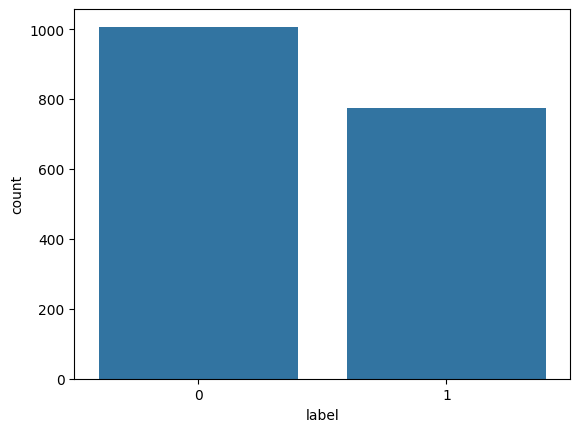

In [63]:
import seaborn as sns
sns.countplot(data = df, x = 'label');

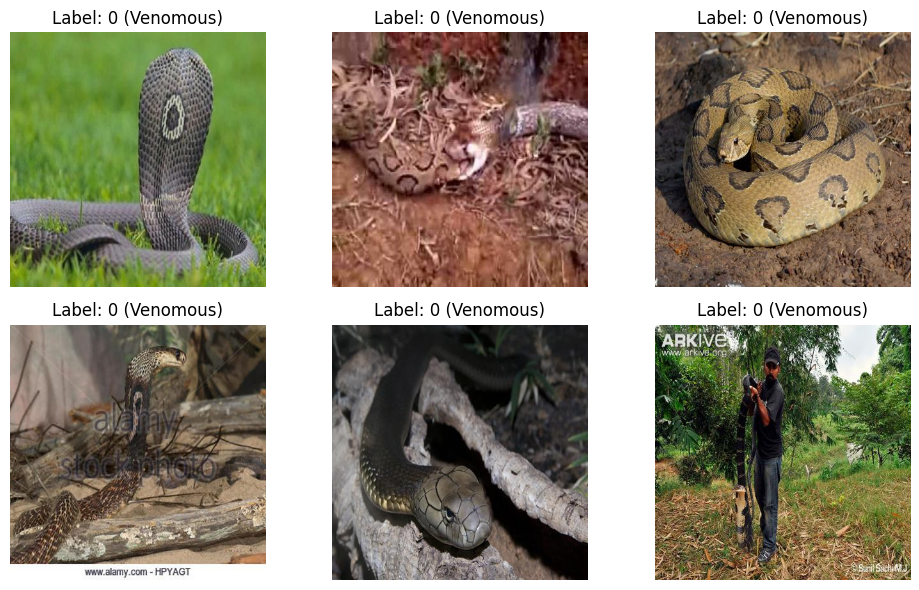

In [64]:
fig, ax = plt.subplots(2, 3, figsize=(10, 6))

idx = 0
for i in range(2):
    for j in range(3):

        label = df.label[idx]
        file_path = os.path.join(root_dir, df.file_name[idx])

        # Read an image with OpenCV
        image = cv2.imread(file_path)

        # Convert the image to RGB color space.
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Resize image
        image = cv2.resize(image, (256, 256))

        ax[i,j].imshow(image)
        ax[i,j].set_title(f"Label: {label} ({'Venomous' if label == 0 else 'Non_Venomous'})")
        ax[i,j].axis('off')
        idx = idx+1

plt.tight_layout()
plt.show()

In [65]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, 
                                      test_size = 0.1, 
                                      random_state = 42)

In [66]:
from types import SimpleNamespace

cfg = SimpleNamespace(**{})

In [67]:
cfg.root_dir = "Snake_Images/train/" # Insert your data here
cfg.image_size = 256

class CustomDataset(Dataset):
    def __init__(self, 
                 cfg, 
                 df, 
                 transform=None, 
                mode = "val"):
        self.root_dir = cfg.root_dir
        self.df = df
        self.file_names = df['file_name'].values
        self.labels = df['label'].values

        if transform:
          self.transform = transform
        else:
          self.transform = A.Compose([
                              A.Resize(cfg.image_size, cfg.image_size), 
                              ToTensorV2(),
                           ])

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # Get file_path and label for index
        label = self.labels[idx]
        file_path = os.path.join(self.root_dir, self.file_names[idx])

        # Read an image with OpenCV
        image = cv2.imread(file_path)

        # Convert the image to RGB color space.
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Apply augmentations        
        augmented = self.transform(image=image)
        image = augmented['image']

        # Normalize because ToTensorV2() doesn't normalize the image
        image = image/255

        return image, label

In [68]:
cfg.batch_size = 32

example_dataset = CustomDataset(cfg, df)

example_dataloader = DataLoader(example_dataset, 
                              batch_size = cfg.batch_size, 
                              shuffle = True, 
                              num_workers=0,
                             )

In [69]:
for (image_batch, label_batch) in example_dataloader:
    print(image_batch.shape)
    print(label_batch.shape)
    break

torch.Size([32, 3, 256, 256])
torch.Size([32])


In [70]:
X = df
y = df.label

train_df, valid_df, y_train, y_test = train_test_split(X, 
                                                       y, 
                                                       test_size = 0.2, 
                                                       random_state = 42)

In [71]:
train_dataset = CustomDataset(cfg, train_df)
valid_dataset = CustomDataset(cfg, valid_df)

train_dataloader = DataLoader(train_dataset, 
                          batch_size = cfg.batch_size, 
                          shuffle = True)

valid_dataloader = DataLoader(valid_dataset, 
                          batch_size = cfg.batch_size, 
                          shuffle = False)

In [72]:
import timm

cfg.n_classes = 2
cfg.backbone = 'resnet34'

model = timm.create_model(cfg.backbone, 
                          pretrained = True, 
                          num_classes = cfg.n_classes)

In [73]:
X = torch.randn(cfg.batch_size, 3, cfg.image_size, cfg.image_size)
y = model(X)

In [74]:
criterion = nn.CrossEntropyLoss()

In [75]:
cfg.learning_rate = 1e-4

optimizer = torch.optim.Adam(
  model.parameters(), 
  lr = cfg.learning_rate, 
  weight_decay = 0,
 )

In [ ]:
cfg.lr_min = 1e-5

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
  optimizer, 
  T_max = np.ceil(len(train_dataloader.dataset) / cfg.batch_size) * cfg.epochs,
  eta_min = cfg.lr_min
)

In [77]:
from sklearn.metrics import accuracy_score

def calculate_metric(y, y_pred):
  metric = accuracy_score(y, y_pred)
  return metric

In [78]:
cfg.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def train_one_epoch(dataloader, model, optimizer, scheduler, cfg):
    # Training mode
    model.train()

    # Init lists to store y and y_pred
    final_y = []
    final_y_pred = []
    final_loss = []

    # Iterate over data
    for step, batch in tqdm(enumerate(dataloader), total=len(dataloader)):
        X = batch[0].to(cfg.device)
        y = batch[1].to(cfg.device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        with torch.set_grad_enabled(True):
            # Forward: Get model outputs
            y_pred = model(X)

            # Forward: Calculate loss
            loss = criterion(y_pred, y)

            # Covert y and y_pred to lists
            y =  y.detach().cpu().numpy().tolist()
            y_pred =  y_pred.detach().cpu().numpy().tolist()

            # Extend original list
            final_y.extend(y)
            final_y_pred.extend(y_pred)
            final_loss.append(loss.item())

            # Backward: Optimize
            loss.backward()
            optimizer.step()

        scheduler.step()

    # Calculate statistics
    loss = np.mean(final_loss)
    final_y_pred = np.argmax(final_y_pred, axis=1)
    metric = calculate_metric(final_y, final_y_pred)

    return metric, loss

In [79]:
def validate_one_epoch(dataloader, model, cfg):
    # Validation mode
    model.eval()

    final_y = []
    final_y_pred = []
    final_loss = []

    # Iterate over data
    for step, batch in tqdm(enumerate(dataloader), total=len(dataloader)):
        X = batch[0].to(cfg.device)
        y = batch[1].to(cfg.device)

        with torch.no_grad():
            # Forward: Get model outputs
            y_pred = model(X)

            # Forward: Calculate loss
            loss = criterion(y_pred, y)  

            # Covert y and y_pred to lists
            y =  y.detach().cpu().numpy().tolist()
            y_pred =  y_pred.detach().cpu().numpy().tolist()

            # Extend original list
            final_y.extend(y)
            final_y_pred.extend(y_pred)
            final_loss.append(loss.item())

    # Calculate statistics
    loss = np.mean(final_loss)
    final_y_pred = np.argmax(final_y_pred, axis=1)
    metric = calculate_metric(final_y, final_y_pred)

    return metric, loss

In [80]:
from sklearn.model_selection import StratifiedKFold

cfg.n_folds = 5

# Create a new column for cross-validation folds
df["kfold"] = -1

# Initialize the kfold class
skf = StratifiedKFold(n_splits=cfg.n_folds)

# Fill the new column
for fold, (train_, val_) in enumerate(skf.split(X = df, y = df.label)):
      df.loc[val_ , "kfold"] = fold

for fold in range(cfg.n_folds):
    train_df = df[df.kfold != fold].reset_index(drop=True)
    valid_df = df[df.kfold == fold].reset_index(drop=True)

In [81]:
transform_soft = A.Compose([A.Resize(cfg.image_size, cfg.image_size),
                             A.Rotate(p=0.6, limit=[-45,45]),
                             A.HorizontalFlip(p = 0.6),
                             A.CoarseDropout(max_holes = 1, max_height = 64, max_width = 64, p=0.3),
                             ToTensorV2()])

/tmp/ipykernel_8259/386701128.py:4: UserWarning: Argument(s) 'max_holes, max_height, max_width' are not valid for transform CoarseDropout
  A.CoarseDropout(max_holes = 1, max_height = 64, max_width = 64, p=0.3),


In [82]:
import random

def set_seed(seed=1234):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)

    # In general seed PyTorch operations
    torch.manual_seed(seed)

    # If you are using CUDA on 1 GPU, seed it
    torch.cuda.manual_seed(seed)

    # If you are using CUDA on more than 1 GPU, seed them all
    torch.cuda.manual_seed_all(cfg.seed)

    # Certain operations in Cudnn are not deterministic, and this line will force them to behave!
    torch.backends.cudnn.deterministic = True 

    # Disable the inbuilt cudnn auto-tuner that finds the best algorithm to use for your hardware.
    torch.backends.cudnn.benchmark = False

In [83]:
cfg.seed = 42

def fit(model, optimizer, scheduler, cfg, train_dataloader, valid_dataloader=None):
    acc_list = []
    loss_list = []
    val_acc_list = []
    val_loss_list = []

    for epoch in range(cfg.epochs):
        print(f"Epoch {epoch + 1}/{cfg.epochs}")

        set_seed(cfg.seed + epoch)

        acc, loss = train_one_epoch(train_dataloader, model, optimizer, scheduler, cfg)

        if valid_dataloader:
            val_acc, val_loss = validate_one_epoch(valid_dataloader, model, cfg)

        print(f'Loss: {loss:.4f} Acc: {acc:.4f}')
        acc_list.append(acc)
        loss_list.append(loss)

        if valid_dataloader:
            print(f'Val Loss: {val_loss:.4f} Val Acc: {val_acc:.4f}')
            val_acc_list.append(val_acc)
            val_loss_list.append(val_loss)

    return acc_list, loss_list, val_acc_list, val_loss_list, model

In [84]:
def visualize_history(acc, loss, val_acc, val_loss):
    fig, ax = plt.subplots(1,2, figsize=(12,4))

    ax[0].plot(range(len(loss)), loss,  color='darkgrey', label = 'train')
    ax[0].plot(range(len(val_loss)), val_loss,  color='cornflowerblue', label = 'valid')
    ax[0].set_title('Loss')

    ax[1].plot(range(len(acc)), acc,  color='darkgrey', label = 'train')
    ax[1].plot(range(len(val_acc)), val_acc,  color='cornflowerblue', label = 'valid')
    ax[1].set_title('Metric (Accuracy)')

    for i in range(2):
        ax[i].set_xlabel('Epochs')
        ax[i].legend(loc="upper right")
    plt.show()

Epoch 1/20


100%|██████████| 12/12 [00:01<00:00,  7.06it/s]


Loss: 0.6842 Acc: 0.5425
Val Loss: 0.6745 Val Acc: 0.5882
Epoch 2/20


100%|██████████| 12/12 [00:01<00:00, 10.01it/s]


Loss: 0.6385 Acc: 0.6393
Val Loss: 0.6166 Val Acc: 0.6723
Epoch 3/20


100%|██████████| 12/12 [00:01<00:00,  9.30it/s]


Loss: 0.5836 Acc: 0.7319
Val Loss: 0.5337 Val Acc: 0.7311
Epoch 4/20


100%|██████████| 12/12 [00:01<00:00, 10.53it/s]


Loss: 0.4886 Acc: 0.8014
Val Loss: 0.4240 Val Acc: 0.8011
Epoch 5/20


100%|██████████| 12/12 [00:01<00:00,  8.21it/s]


Loss: 0.4077 Acc: 0.8449
Val Loss: 0.3526 Val Acc: 0.8431
Epoch 6/20


100%|██████████| 12/12 [00:01<00:00,  7.80it/s]


Loss: 0.3284 Acc: 0.8842
Val Loss: 0.2971 Val Acc: 0.8543
Epoch 7/20


100%|██████████| 12/12 [00:01<00:00,  8.82it/s]


Loss: 0.2741 Acc: 0.9053
Val Loss: 0.2593 Val Acc: 0.8683
Epoch 8/20


100%|██████████| 12/12 [00:01<00:00,  8.14it/s]


Loss: 0.2142 Acc: 0.9277
Val Loss: 0.2415 Val Acc: 0.8711
Epoch 9/20


100%|██████████| 12/12 [00:01<00:00, 10.18it/s]


Loss: 0.1818 Acc: 0.9354
Val Loss: 0.2254 Val Acc: 0.8824
Epoch 10/20


100%|██████████| 12/12 [00:01<00:00,  9.87it/s]


Loss: 0.1680 Acc: 0.9446
Val Loss: 0.2085 Val Acc: 0.9020
Epoch 11/20


100%|██████████| 12/12 [00:01<00:00, 10.52it/s]


Loss: 0.1340 Acc: 0.9593
Val Loss: 0.1985 Val Acc: 0.9076
Epoch 12/20


100%|██████████| 12/12 [00:01<00:00, 10.23it/s]


Loss: 0.1447 Acc: 0.9551
Val Loss: 0.1934 Val Acc: 0.9104
Epoch 13/20


100%|██████████| 12/12 [00:01<00:00,  8.08it/s]


Loss: 0.1308 Acc: 0.9551
Val Loss: 0.1953 Val Acc: 0.9020
Epoch 14/20


100%|██████████| 12/12 [00:01<00:00,  8.47it/s]


Loss: 0.1101 Acc: 0.9747
Val Loss: 0.1835 Val Acc: 0.9104
Epoch 15/20


100%|██████████| 12/12 [00:01<00:00,  9.18it/s]


Loss: 0.1066 Acc: 0.9649
Val Loss: 0.1839 Val Acc: 0.9104
Epoch 16/20


100%|██████████| 12/12 [00:01<00:00,  7.77it/s]


Loss: 0.1003 Acc: 0.9726
Val Loss: 0.1823 Val Acc: 0.9160
Epoch 17/20


100%|██████████| 12/12 [00:01<00:00,  7.87it/s]


Loss: 0.1005 Acc: 0.9712
Val Loss: 0.1814 Val Acc: 0.9160
Epoch 18/20


100%|██████████| 12/12 [00:01<00:00, 10.31it/s]


Loss: 0.0953 Acc: 0.9691
Val Loss: 0.1799 Val Acc: 0.9244
Epoch 19/20


100%|██████████| 12/12 [00:01<00:00,  9.68it/s]


Loss: 0.0864 Acc: 0.9811
Val Loss: 0.1805 Val Acc: 0.9216
Epoch 20/20


100%|██████████| 12/12 [00:01<00:00,  8.67it/s]


Loss: 0.0818 Acc: 0.9796
Val Loss: 0.1916 Val Acc: 0.8936


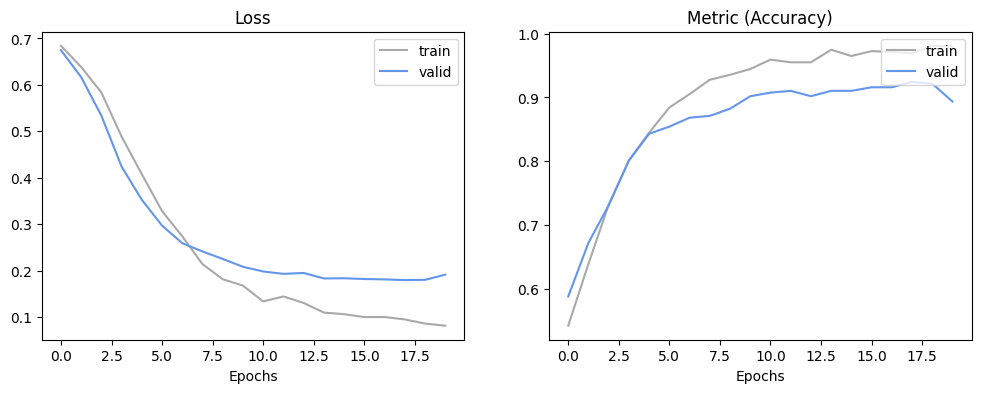

Epoch 1/20


100%|██████████| 12/12 [00:01<00:00,  8.01it/s]


Loss: 0.6778 Acc: 0.5754
Val Loss: 0.6592 Val Acc: 0.5994
Epoch 2/20


100%|██████████| 12/12 [00:01<00:00,  7.50it/s]


Loss: 0.6230 Acc: 0.6695
Val Loss: 0.6139 Val Acc: 0.7143
Epoch 3/20


100%|██████████| 12/12 [00:01<00:00,  6.51it/s]


Loss: 0.5523 Acc: 0.7642
Val Loss: 0.5446 Val Acc: 0.7675
Epoch 4/20


100%|██████████| 12/12 [00:01<00:00,  7.53it/s]


Loss: 0.4644 Acc: 0.8204
Val Loss: 0.4585 Val Acc: 0.8235
Epoch 5/20


100%|██████████| 12/12 [00:01<00:00,  7.23it/s]


Loss: 0.3715 Acc: 0.8639
Val Loss: 0.3934 Val Acc: 0.8347
Epoch 6/20


100%|██████████| 12/12 [00:01<00:00,  7.98it/s]


Loss: 0.3041 Acc: 0.8933
Val Loss: 0.3546 Val Acc: 0.8459
Epoch 7/20


100%|██████████| 12/12 [00:01<00:00,  7.05it/s]


Loss: 0.2388 Acc: 0.9242
Val Loss: 0.3257 Val Acc: 0.8515
Epoch 8/20


100%|██████████| 12/12 [00:01<00:00,  9.89it/s]


Loss: 0.2020 Acc: 0.9375
Val Loss: 0.3089 Val Acc: 0.8683
Epoch 9/20


100%|██████████| 12/12 [00:01<00:00,  9.78it/s]


Loss: 0.1681 Acc: 0.9432
Val Loss: 0.2922 Val Acc: 0.8852
Epoch 10/20


100%|██████████| 12/12 [00:01<00:00,  7.63it/s]


Loss: 0.1606 Acc: 0.9502
Val Loss: 0.2843 Val Acc: 0.8852
Epoch 11/20


100%|██████████| 12/12 [00:01<00:00,  6.68it/s]


Loss: 0.1288 Acc: 0.9621
Val Loss: 0.2809 Val Acc: 0.8852
Epoch 12/20


100%|██████████| 12/12 [00:01<00:00, 10.27it/s]


Loss: 0.1224 Acc: 0.9649
Val Loss: 0.2737 Val Acc: 0.8824
Epoch 13/20


100%|██████████| 12/12 [00:01<00:00,  8.51it/s]


Loss: 0.1246 Acc: 0.9607
Val Loss: 0.2681 Val Acc: 0.8992
Epoch 14/20


100%|██████████| 12/12 [00:01<00:00,  9.98it/s]


Loss: 0.1059 Acc: 0.9677
Val Loss: 0.2696 Val Acc: 0.8852
Epoch 15/20


100%|██████████| 12/12 [00:01<00:00,  7.55it/s]


Loss: 0.0921 Acc: 0.9775
Val Loss: 0.2637 Val Acc: 0.8908
Epoch 16/20


100%|██████████| 12/12 [00:01<00:00, 10.05it/s]


Loss: 0.0829 Acc: 0.9832
Val Loss: 0.2582 Val Acc: 0.8964
Epoch 17/20


100%|██████████| 12/12 [00:01<00:00,  7.29it/s]


Loss: 0.0989 Acc: 0.9705
Val Loss: 0.2669 Val Acc: 0.8936
Epoch 18/20


100%|██████████| 12/12 [00:01<00:00,  8.44it/s]


Loss: 0.0731 Acc: 0.9874
Val Loss: 0.2642 Val Acc: 0.8992
Epoch 19/20


100%|██████████| 12/12 [00:01<00:00,  9.53it/s]


Loss: 0.0780 Acc: 0.9782
Val Loss: 0.2681 Val Acc: 0.9048
Epoch 20/20


100%|██████████| 12/12 [00:01<00:00,  7.46it/s]


Loss: 0.0702 Acc: 0.9846
Val Loss: 0.2678 Val Acc: 0.9048


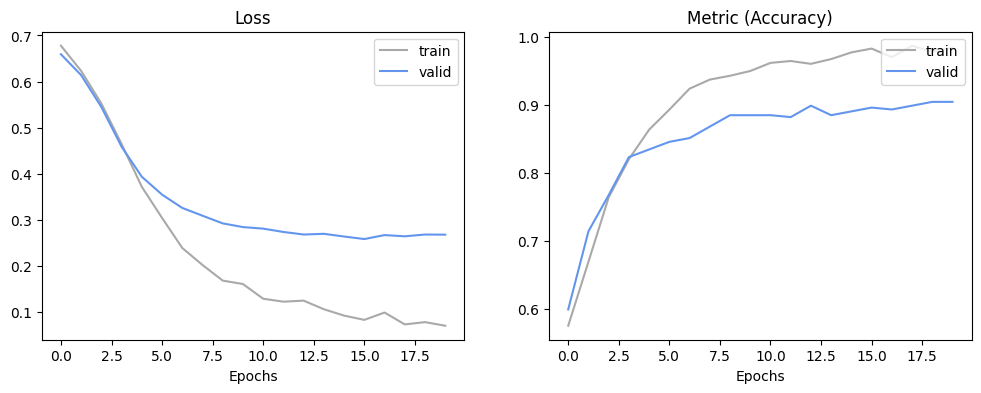

Epoch 1/20


100%|██████████| 12/12 [00:01<00:00,  7.35it/s]


Loss: 0.6795 Acc: 0.5435
Val Loss: 0.6670 Val Acc: 0.6180
Epoch 2/20


100%|██████████| 12/12 [00:01<00:00,  9.95it/s]


Loss: 0.6243 Acc: 0.6774
Val Loss: 0.6338 Val Acc: 0.6433
Epoch 3/20


100%|██████████| 12/12 [00:01<00:00,  8.16it/s]


Loss: 0.5632 Acc: 0.7574
Val Loss: 0.5585 Val Acc: 0.7697
Epoch 4/20


100%|██████████| 12/12 [00:01<00:00,  8.94it/s]


Loss: 0.4796 Acc: 0.8184
Val Loss: 0.4848 Val Acc: 0.8202
Epoch 5/20


100%|██████████| 12/12 [00:01<00:00,  9.59it/s]


Loss: 0.3994 Acc: 0.8499
Val Loss: 0.4169 Val Acc: 0.8539
Epoch 6/20


100%|██████████| 12/12 [00:01<00:00,  7.42it/s]


Loss: 0.3385 Acc: 0.8696
Val Loss: 0.3859 Val Acc: 0.8567
Epoch 7/20


100%|██████████| 12/12 [00:01<00:00,  7.04it/s]


Loss: 0.2732 Acc: 0.9011
Val Loss: 0.3271 Val Acc: 0.8652
Epoch 8/20


100%|██████████| 12/12 [00:01<00:00,  8.01it/s]


Loss: 0.2380 Acc: 0.9123
Val Loss: 0.3007 Val Acc: 0.8848
Epoch 9/20


100%|██████████| 12/12 [00:01<00:00,  8.45it/s]


Loss: 0.2124 Acc: 0.9299
Val Loss: 0.2907 Val Acc: 0.8820
Epoch 10/20


100%|██████████| 12/12 [00:01<00:00,  7.72it/s]


Loss: 0.1841 Acc: 0.9341
Val Loss: 0.2724 Val Acc: 0.9017
Epoch 11/20


100%|██████████| 12/12 [00:01<00:00,  7.57it/s]


Loss: 0.1659 Acc: 0.9425
Val Loss: 0.2681 Val Acc: 0.8904
Epoch 12/20


100%|██████████| 12/12 [00:01<00:00,  7.60it/s]


Loss: 0.1509 Acc: 0.9523
Val Loss: 0.2678 Val Acc: 0.9045
Epoch 13/20


100%|██████████| 12/12 [00:01<00:00,  7.35it/s]


Loss: 0.1408 Acc: 0.9530
Val Loss: 0.2360 Val Acc: 0.9045
Epoch 14/20


100%|██████████| 12/12 [00:01<00:00,  7.38it/s]


Loss: 0.1375 Acc: 0.9481
Val Loss: 0.2349 Val Acc: 0.9045
Epoch 15/20


100%|██████████| 12/12 [00:01<00:00,  8.72it/s]


Loss: 0.1248 Acc: 0.9593
Val Loss: 0.2318 Val Acc: 0.9017
Epoch 16/20


100%|██████████| 12/12 [00:01<00:00,  7.43it/s]


Loss: 0.1155 Acc: 0.9677
Val Loss: 0.2208 Val Acc: 0.9073
Epoch 17/20


100%|██████████| 12/12 [00:01<00:00,  8.78it/s]


Loss: 0.1096 Acc: 0.9719
Val Loss: 0.2286 Val Acc: 0.9073
Epoch 18/20


100%|██████████| 12/12 [00:01<00:00,  6.87it/s]


Loss: 0.1077 Acc: 0.9698
Val Loss: 0.2272 Val Acc: 0.9045
Epoch 19/20


100%|██████████| 12/12 [00:01<00:00,  7.52it/s]


Loss: 0.1002 Acc: 0.9684
Val Loss: 0.2236 Val Acc: 0.9045
Epoch 20/20


100%|██████████| 12/12 [00:01<00:00,  8.78it/s]


Loss: 0.1064 Acc: 0.9677
Val Loss: 0.2376 Val Acc: 0.9017


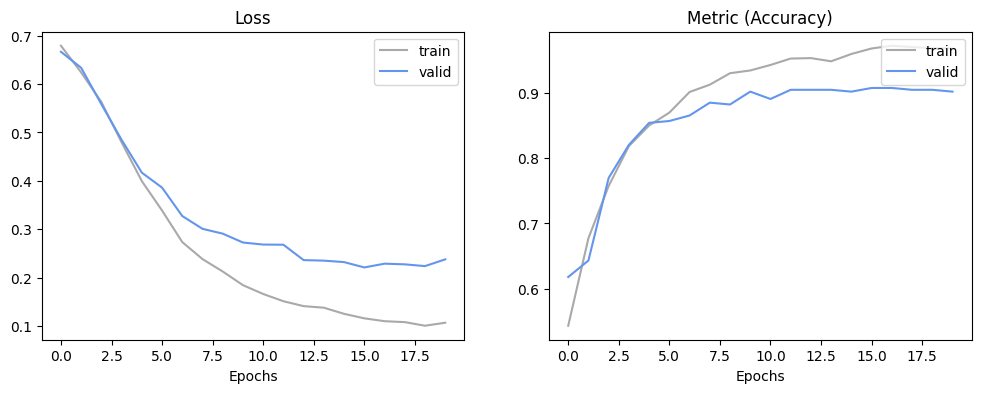

Epoch 1/20


100%|██████████| 12/12 [00:01<00:00, 10.59it/s]


Loss: 0.6795 Acc: 0.5582
Val Loss: 0.6678 Val Acc: 0.6124
Epoch 2/20


100%|██████████| 12/12 [00:01<00:00,  9.48it/s]


Loss: 0.6278 Acc: 0.6634
Val Loss: 0.6276 Val Acc: 0.6517
Epoch 3/20


100%|██████████| 12/12 [00:01<00:00,  9.60it/s]


Loss: 0.5600 Acc: 0.7700
Val Loss: 0.5382 Val Acc: 0.7612
Epoch 4/20


100%|██████████| 12/12 [00:01<00:00,  7.78it/s]


Loss: 0.4726 Acc: 0.8114
Val Loss: 0.4470 Val Acc: 0.8174
Epoch 5/20


100%|██████████| 12/12 [00:01<00:00,  9.34it/s]


Loss: 0.3865 Acc: 0.8604
Val Loss: 0.3787 Val Acc: 0.8455
Epoch 6/20


100%|██████████| 12/12 [00:01<00:00,  8.10it/s]


Loss: 0.3224 Acc: 0.8871
Val Loss: 0.3465 Val Acc: 0.8652
Epoch 7/20


100%|██████████| 12/12 [00:01<00:00, 10.10it/s]


Loss: 0.2704 Acc: 0.8976
Val Loss: 0.3100 Val Acc: 0.8680
Epoch 8/20


100%|██████████| 12/12 [00:01<00:00,  8.53it/s]


Loss: 0.2309 Acc: 0.9194
Val Loss: 0.2868 Val Acc: 0.9017
Epoch 9/20


100%|██████████| 12/12 [00:01<00:00,  8.89it/s]


Loss: 0.2059 Acc: 0.9285
Val Loss: 0.2774 Val Acc: 0.8961
Epoch 10/20


100%|██████████| 12/12 [00:01<00:00,  9.13it/s]


Loss: 0.1781 Acc: 0.9390
Val Loss: 0.2662 Val Acc: 0.8989
Epoch 11/20


100%|██████████| 12/12 [00:01<00:00, 10.32it/s]


Loss: 0.1652 Acc: 0.9439
Val Loss: 0.2595 Val Acc: 0.9129
Epoch 12/20


100%|██████████| 12/12 [00:01<00:00,  7.91it/s]


Loss: 0.1486 Acc: 0.9530
Val Loss: 0.2486 Val Acc: 0.9073
Epoch 13/20


100%|██████████| 12/12 [00:01<00:00,  6.39it/s]


Loss: 0.1438 Acc: 0.9579
Val Loss: 0.2408 Val Acc: 0.9129
Epoch 14/20


100%|██████████| 12/12 [00:01<00:00,  7.98it/s]


Loss: 0.1289 Acc: 0.9593
Val Loss: 0.2429 Val Acc: 0.9073
Epoch 15/20


100%|██████████| 12/12 [00:01<00:00, 10.27it/s]


Loss: 0.1197 Acc: 0.9593
Val Loss: 0.2263 Val Acc: 0.9129
Epoch 16/20


100%|██████████| 12/12 [00:01<00:00,  7.16it/s]


Loss: 0.1140 Acc: 0.9691
Val Loss: 0.2286 Val Acc: 0.9157
Epoch 17/20


100%|██████████| 12/12 [00:01<00:00,  9.20it/s]


Loss: 0.1145 Acc: 0.9649
Val Loss: 0.2273 Val Acc: 0.9101
Epoch 18/20


100%|██████████| 12/12 [00:01<00:00,  8.21it/s]


Loss: 0.1142 Acc: 0.9663
Val Loss: 0.2301 Val Acc: 0.9242
Epoch 19/20


100%|██████████| 12/12 [00:01<00:00,  8.92it/s]


Loss: 0.0987 Acc: 0.9705
Val Loss: 0.2264 Val Acc: 0.9129
Epoch 20/20


100%|██████████| 12/12 [00:01<00:00,  8.52it/s]


Loss: 0.1026 Acc: 0.9734
Val Loss: 0.2411 Val Acc: 0.9270


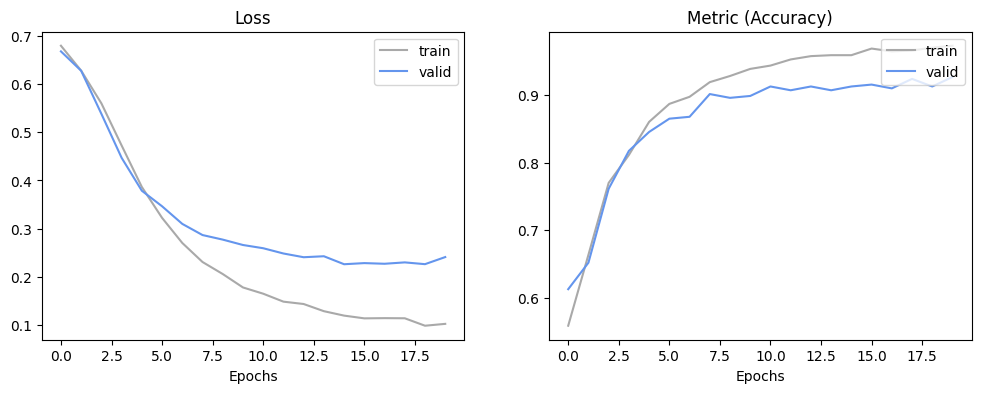

Epoch 1/20


100%|██████████| 12/12 [00:01<00:00, 10.34it/s]


Loss: 0.6780 Acc: 0.5582
Val Loss: 0.6645 Val Acc: 0.6124
Epoch 2/20


100%|██████████| 12/12 [00:01<00:00,  7.48it/s]


Loss: 0.6230 Acc: 0.6711
Val Loss: 0.6143 Val Acc: 0.6573
Epoch 3/20


100%|██████████| 12/12 [00:01<00:00,  9.58it/s]


Loss: 0.5553 Acc: 0.7644
Val Loss: 0.5318 Val Acc: 0.7697
Epoch 4/20


100%|██████████| 12/12 [00:01<00:00,  8.01it/s]


Loss: 0.4770 Acc: 0.8065
Val Loss: 0.4449 Val Acc: 0.8230
Epoch 5/20


100%|██████████| 12/12 [00:01<00:00,  6.86it/s]


Loss: 0.3895 Acc: 0.8569
Val Loss: 0.3995 Val Acc: 0.8567
Epoch 6/20


100%|██████████| 12/12 [00:01<00:00,  7.66it/s]


Loss: 0.3129 Acc: 0.8927
Val Loss: 0.3318 Val Acc: 0.8764
Epoch 7/20


100%|██████████| 12/12 [00:01<00:00,  8.76it/s]


Loss: 0.2556 Acc: 0.8997
Val Loss: 0.3127 Val Acc: 0.8764
Epoch 8/20


100%|██████████| 12/12 [00:01<00:00,  8.06it/s]


Loss: 0.2186 Acc: 0.9278
Val Loss: 0.2778 Val Acc: 0.8848
Epoch 9/20


100%|██████████| 12/12 [00:01<00:00,  7.34it/s]


Loss: 0.1917 Acc: 0.9334
Val Loss: 0.2688 Val Acc: 0.8820
Epoch 10/20


100%|██████████| 12/12 [00:01<00:00,  7.71it/s]


Loss: 0.1620 Acc: 0.9488
Val Loss: 0.2551 Val Acc: 0.8933
Epoch 11/20


100%|██████████| 12/12 [00:01<00:00,  8.04it/s]


Loss: 0.1508 Acc: 0.9509
Val Loss: 0.2765 Val Acc: 0.8989
Epoch 12/20


100%|██████████| 12/12 [00:01<00:00,  8.43it/s]


Loss: 0.1304 Acc: 0.9614
Val Loss: 0.2552 Val Acc: 0.8933
Epoch 13/20


100%|██████████| 12/12 [00:01<00:00,  9.76it/s]


Loss: 0.1249 Acc: 0.9698
Val Loss: 0.2547 Val Acc: 0.8904
Epoch 14/20


100%|██████████| 12/12 [00:01<00:00,  8.70it/s]


Loss: 0.1232 Acc: 0.9642
Val Loss: 0.2478 Val Acc: 0.9045
Epoch 15/20


100%|██████████| 12/12 [00:01<00:00,  8.64it/s]


Loss: 0.1047 Acc: 0.9727
Val Loss: 0.2489 Val Acc: 0.8989
Epoch 16/20


100%|██████████| 12/12 [00:01<00:00,  8.47it/s]


Loss: 0.1114 Acc: 0.9677
Val Loss: 0.2467 Val Acc: 0.8989
Epoch 17/20


100%|██████████| 12/12 [00:01<00:00,  8.25it/s]


Loss: 0.1011 Acc: 0.9684
Val Loss: 0.2523 Val Acc: 0.8933
Epoch 18/20


100%|██████████| 12/12 [00:01<00:00,  7.47it/s]


Loss: 0.0954 Acc: 0.9734
Val Loss: 0.2454 Val Acc: 0.9017
Epoch 19/20


100%|██████████| 12/12 [00:01<00:00, 10.36it/s]


Loss: 0.0845 Acc: 0.9797
Val Loss: 0.2478 Val Acc: 0.8989
Epoch 20/20


100%|██████████| 12/12 [00:01<00:00,  7.76it/s]


Loss: 0.0908 Acc: 0.9755
Val Loss: 0.2629 Val Acc: 0.8961


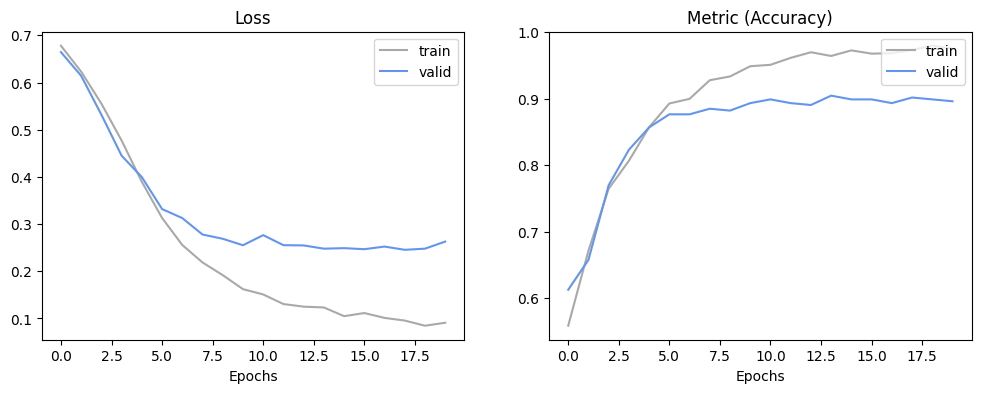

In [85]:
for fold in range(cfg.n_folds):
    train_df = df[df.kfold != fold].reset_index(drop=True)
    valid_df = df[df.kfold == fold].reset_index(drop=True)

    train_dataset = CustomDataset(cfg, train_df, transform = transform_soft)
    valid_dataset = CustomDataset(cfg, valid_df)

    train_dataloader = DataLoader(train_dataset, 
                              batch_size = cfg.batch_size, 
                              shuffle = True, 
                              num_workers = 0,
                             )
    valid_dataloader = DataLoader(valid_dataset, 
                              batch_size = cfg.batch_size, 
                              shuffle = False, 
                              num_workers = 0,
                             )

    model = timm.create_model(cfg.backbone, 
                              pretrained = True, 
                              num_classes = cfg.n_classes)

    model = model.to(cfg.device)

    criterion = nn.CrossEntropyLoss()

    optimizer = torch.optim.Adam(model.parameters(), 
                                 lr = cfg.learning_rate, 
                                 weight_decay = 0,
                                )

    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 
                                                           T_max= np.ceil(len(train_dataloader.dataset) / cfg.batch_size) * cfg.epochs,
                                                           eta_min=cfg.lr_min)

    acc, loss, val_acc, val_loss, model = fit(model, optimizer, scheduler, cfg, train_dataloader, valid_dataloader)

    visualize_history(acc, loss, val_acc, val_loss)